Agatha Justina Majcher  
M.Sc. Renewable Energy Systems

# Distributional Analysis of the Carbon Tax in South Africa

Part II - PyPSA-ZA  
Revenue Recycling through Investment in Renewable Energies

# 1. Setup

In [2]:
import sys
sys.path.append("~/Desktop/pypsa-za-master")

In [3]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("bmh")
%matplotlib inline

In [43]:
import pandas as pd
import geopandas as gpd
import numpy
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib.patches import Circle, Ellipse
from matplotlib.legend_handler import HandlerPatch
from vresutils import plot as vplot
from vresutils import Dict

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)

In [5]:
# solved_network files

n275oc = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc")
n275wc = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275wc.nc")
n96 = pypsa.Network("~/Desktop/final_networks/solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_96oc.nc")



INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275oc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_275wc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units
INFO:pypsa.io:Imported network solved_val-2Gt-IRP_27-supply_redz_lcopt_Co2L-1H_96oc.nc has buses, carriers, generators, global_constraints, lines, loads, storage_units


In [138]:
# setup for plots
colors = {
    "onwind": "#77D1E4",
    "hydro": "#004F95",
    "hydro-import": "#004F95",
    "CSP": "#FEED82",
    "solar": "#FFBB4E",
    "biomass": "#0c6013",
    "CCGT": "#CCC8C8",
    "OCGT": "#8D7867",
    "nuclear": "#C84936",
    "gas": "grey",
    "coal": "#3C3C3C",
}

nice_names = {
    'nuclear': 'Nuclear',
    'coal': 'Coal',
    'CCGT': 'CCGT',
    'OCGT': 'OCGT',
    'gas': 'Gas',
    'onwind': 'Wind',
    'hydro': 'Hydro',
    'hydro-import': 'Hydro Import',
    'solar': 'PV',
    'CSP': 'CSP',
    'biomass': 'Biomass',
}

# 2. Share Renewables Energies

#### Time Series per Carrier and _t.p

In [13]:
n96.generators_t.p.sum().groupby(n96.generators.carrier).sum()

carrier
CCGT             0.000000e+00
CSP              1.986336e+06
OCGT             2.425088e+05
biomass          9.567008e+05
coal             1.017557e+08
gas              4.859458e+05
hydro            4.960680e+06
hydro-import     9.730947e+06
load_shedding    0.000000e+00
nuclear          1.344281e+07
onwind           9.553330e+07
solar            4.925683e+07
dtype: float64

In [242]:
# Total generation in GW
n96.generators_t.p.sum().sum()/8760/1e3

31.77530917962265

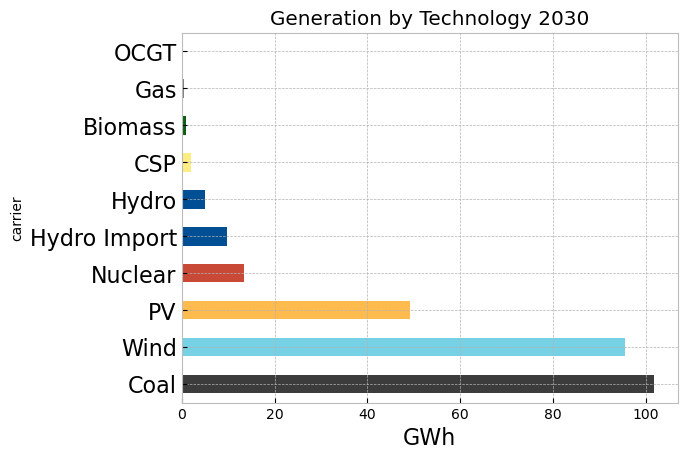

In [191]:
# Group by carrier and sum p_nom, divide by 1000 to convert to GW
a = n96.generators_t.p.sum().groupby(n96.generators.carrier).sum().div(1e6)
a = a[a != 0] 

carrier_order = ['onwind', 'solar', 'CSP', 'hydro', 'hydro-import', 'biomass', 'gas', 'OCGT', 'nuclear', 'coal']
a_sorted = a.loc[carrier_order].sort_values(ascending=False)

# Create horizontal bar chart
ax = a_sorted.plot.barh(color=[colors.get(carrier, '#333333') for carrier in a_sorted.index])
ax.set_xlabel('GWh', fontsize=16)
ax.set_title('Generation by Technology 2030')

ax.set_facecolor('white')

# Replace carrier names with nice names
ax.set_yticklabels([nice_names.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()],fontsize=16)

# Save plot as PNG with descriptive file name
plt.savefig('balken96.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

#### Generated Electricity per Day

In [174]:
# power (MW) sum of 8760h /24h - MW per day /1000 - GW per day
p_by_carrier = n96.generators_t.p.groupby(n96.generators.carrier, axis=1).sum().div(24).div(1e3)
p_by_carrier = p_by_carrier.droplevel(level='period')
p_by_carrier = p_by_carrier.drop(columns=["load_shedding"])

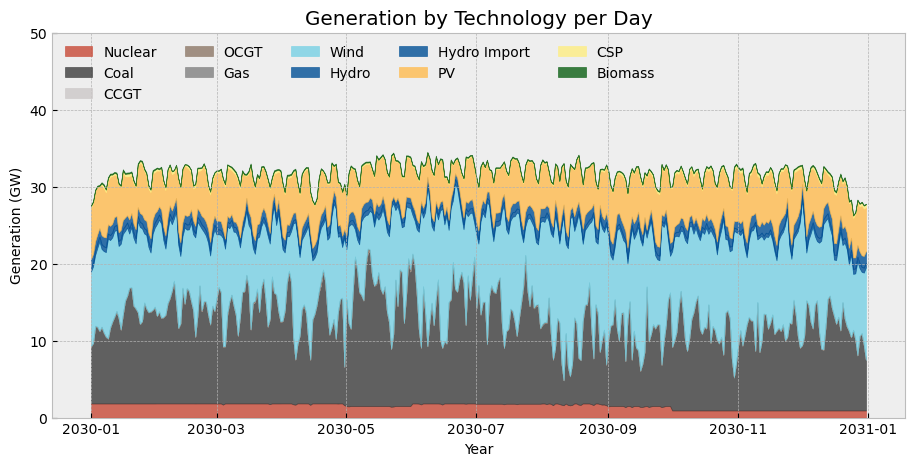

In [192]:
p_by_carrier_resampled = p_by_carrier.resample("D").sum()
stacked = p_by_carrier_resampled.stack().reset_index()
stacked.columns = ['week', 'carrier', 'GW']
stacked = stacked.pivot(index='week', columns='carrier', values='GW')
bottom = 0


fig, ax = plt.subplots(figsize=(11, 5))
bottom = 0
for carrier in nice_names:
    data = stacked[carrier]
    ax.fill_between(
        data.index, bottom, bottom + data, 
        color=colors[carrier], alpha=0.8, label=nice_names[carrier]
    )
    bottom += data

# add legend and axis labels
ax.legend(ncol=5, loc="upper left", frameon=False)
ax.set_xlabel("Year")
ax.set_ylabel("Generation (GW)")
ax.set_title("Generation by Technology per Day")
ax.set_ylim(0,50);

# Save plot as PNG
plt.savefig('generation96.png', dpi=600,facecolor='white', bbox_inches='tight')

plt.show()

In [ ]:
#### Storage Unit

In [199]:
a = n96.storage_units_t.p.sum()
a = a.loc[a != 0]
a

StorageUnit
Drakensberg   -351926.838108
Ingula        -841607.631139
Palmiet       -186731.766744
Steenbras      -10952.274573
dtype: float64

In [213]:
a.sum()/8760 #MW

-158.81489846625124

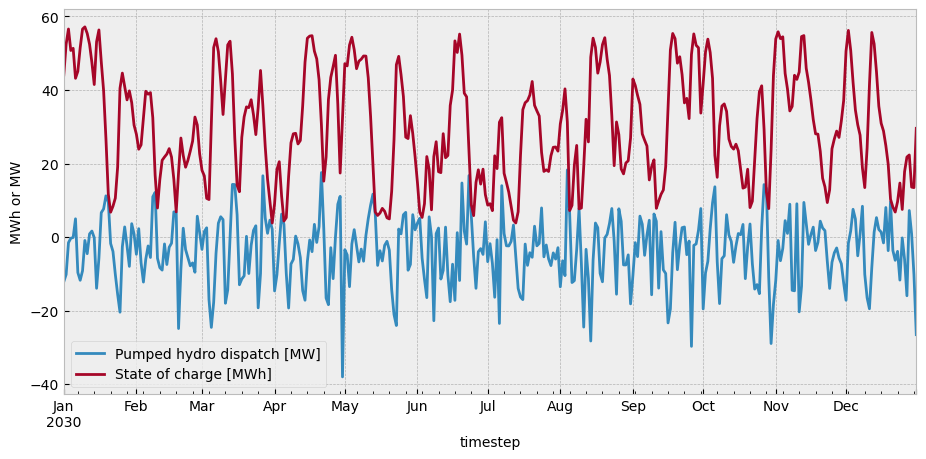

In [211]:
fig, ax = plt.subplots(figsize=(11, 5))

p_storage = n96.storage_units_t.p.sum(axis=1).div(1e3)
p_storage = p_storage.droplevel(level='period')
p_storage = p_storage.resample("D").sum()
state_of_charge = n96.storage_units_t.state_of_charge.sum(axis=1).div(1e3)/24
state_of_charge = state_of_charge.droplevel(level='period')
state_of_charge = state_of_charge.resample("D").sum()

p_storage.plot(label="Pumped hydro dispatch [MW]", ax=ax)
state_of_charge.plot(label="State of charge [MWh]", ax=ax)

ax.grid(True)
ax.legend()
ax.set_ylabel("MWh or MW")

plt.savefig("storage96.png")

#### Power Flow

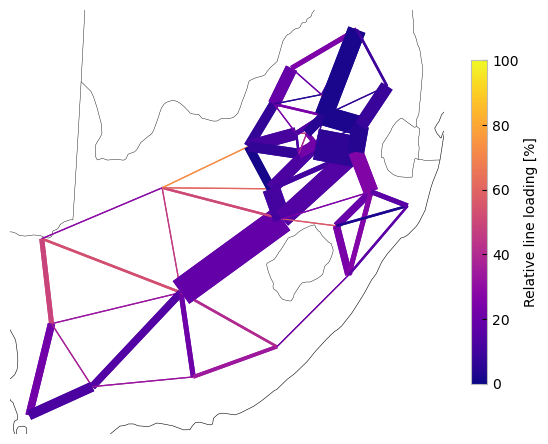

In [57]:
line_loading = n96.lines_t.p0.iloc[0].abs() / n96.lines.s_nom_opt / n96.lines.s_max_pu * 100 # %

norm = plt.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.EqualEarth())

n96.plot(
    ax=ax,
    bus_sizes=0,
    line_colors=line_loading,
    line_norm=norm,
    line_cmap='plasma',
    line_widths=n96.lines.s_nom_opt/ 1000
);

plt.colorbar(
    plt.cm.ScalarMappable(cmap='plasma', norm=norm),
    label='Relative line loading [%]',
    shrink=0.6
)

### Transmission Line Expansion

In [216]:
(n96.lines.s_nom_opt - n96.lines.s_nom).head(5)

Line
0    3574.952867
1    5362.429300
2     893.738217
3     893.738217
4     893.738217
dtype: float64

In [ ]:
## Line flows

In [217]:
line_flows = n96.lines_t.p0
print(line_flows)

Line                                  0            1           2           3  \
period timestep                                                                
2030   2030-01-01 00:00:00  1227.841384  -815.797484 -229.942499 -206.785418   
       2030-01-01 01:00:00  1191.375646  -777.874140 -224.024665 -200.851612   
       2030-01-01 02:00:00  1134.702514  -740.559163 -215.274575 -181.525920   
       2030-01-01 03:00:00  1019.953543  -661.638625 -193.226104 -157.537195   
       2030-01-01 04:00:00   893.475330  -571.481093 -168.302803 -132.612487   
...                                 ...          ...         ...         ...   
       2030-12-31 19:00:00  1410.292289 -1073.902128 -261.928255 -247.712937   
       2030-12-31 20:00:00  1455.274850 -1112.787322 -262.074959 -238.133052   
       2030-12-31 21:00:00  1468.238994 -1099.749563 -265.473997 -247.313242   
       2030-12-31 22:00:00  1433.248472 -1060.767650 -259.427673 -245.886132   
       2030-12-31 23:00:00  1411.067410 

# 3. Total Annual System Costs in billion

In [219]:
n96.objective/1e9 

231.87762722845562

In [220]:
n96.objective.sum()/1e9




231.87762722845562

In [221]:
# Calculate the annual system costs
annual_costs = n96.objective.sum()

# Sum up the annual system costs over the years
yearly_costs = annual_costs.groupby(annual_costs.index.period).sum()

# Print the total costs over the simulation period
total_costs = yearly_costs.sum()
print(f"Total system costs for the simulation period: {total_costs:.2f} ZAR")

AttributeError: 'numpy.float64' object has no attribute 'groupby'

In [255]:
total_cost_bus = (n96.loads_t.p * n96.buses_t.marginal_price).sum()

In [ ]:
n96.generators

In [258]:
n96.lines.marginal_price

AttributeError: 'DataFrame' object has no attribute 'marginal_price'

In [254]:
total_cost_gen = n96.generators.p_nom_opt.multiply(n96.generators.costs, axis=0).sum().sum()


AttributeError: 'DataFrame' object has no attribute 'costs'

# 4. CO2 Emissions

In [ ]:
#### Total CO2 emissions by the network (efficiency and fuel source)

In [223]:
emissions = n96.generators_t.p / n96.generators.efficiency * n96.generators.carrier.map(n96.carriers.co2_emissions)
emissions.sum().sum() / 1e6 #Mt

96.0000002477122

In [9]:
#### Plot total CO2 emissions per day

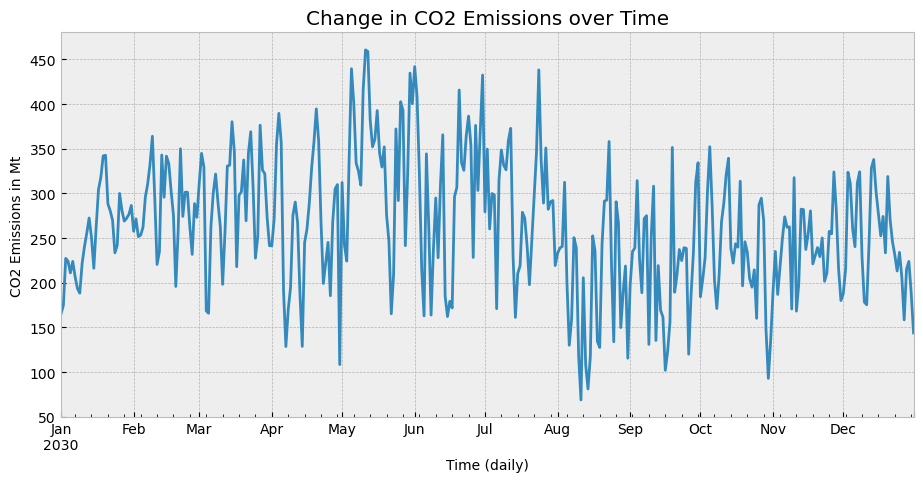

In [259]:
emissions = (n96.generators_t.p / n96.generators.efficiency * n96.generators.carrier.map(n96.carriers.co2_emissions)).sum(axis=1)
emissions = emissions.droplevel(level='period')
emissions = emissions.resample("D").sum()/1e3


emissions.plot(figsize=(11, 5), title='Change in CO2 Emissions over Time', 
               xlabel='Time (daily)', ylabel='CO2 Emissions in kt')

plt.savefig("emissions96.png")

In [ ]:
# Emissions per kWh

In [241]:
a = n96.generators_t.p.sum().groupby(n96.generators.carrier).sum()/8790/1e3
a = a.drop(columns=["load_shedding"])
a

carrier
CCGT              0.000000
CSP               0.225977
OCGT              0.027589
biomass           0.108840
coal             11.576297
gas               0.055284
hydro             0.564355
hydro-import      1.107047
load_shedding     0.000000
nuclear           1.529329
onwind           10.868407
solar             5.603735
dtype: float64

In [243]:
a.sum()

31.666861025425984

In [230]:
n96.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
CSP,0.0000,#FEED82,Csp,inf
biomass,0.0000,#0c6013,Biomass,inf
PHS,0.0000,#004F95,Pumped Hydro Storage,inf
coal,0.3000,#3C3C3C,Coal,inf
gas,0.1794,#d35050,Gas,inf
hydro,0.0000,#004F95,Hydro,inf
hydro-import,0.0000,#004F95,Hydro import,inf
nuclear,0.0000,#C84936,Nuclear,inf
CCGT,0.1794,#CCC8C8,CCGT,inf


In [ ]:
# Electricity from coal - 1000g/kW
                # gas - 500g/kW